**Data is ended at 2014-03-31, and it collects customer travel records in two years.**

**1. Exploring data to check missing value and outliers**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

datafile = 'air_data.csv'
data = pd.read_csv(datafile, encoding = 'utf-8')
data.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,ADD_Point_SUM,Eli_Add_Point_Sum,L1Y_ELi_Add_Points,Points_Sum,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight
0,54993,2006/11/02,2008/12/24,男,6,.,北京,CN,31.0,2014/03/31,...,39992,114452,111100,619760,370211,0.509524,0.490476,0.487221,0.512777,50
1,28065,2007/02/19,2007/08/03,男,6,NaN,北京,CN,42.0,2014/03/31,...,12000,53288,53288,415768,238410,0.514286,0.485714,0.489289,0.510708,33
2,55106,2007/02/01,2007/08/30,男,6,.,北京,CN,40.0,2014/03/31,...,15491,55202,51711,406361,233798,0.518519,0.481481,0.481467,0.518530,26
3,21189,2008/08/22,2008/08/23,男,5,Los Angeles,CA,US,64.0,2014/03/31,...,0,34890,34890,372204,186100,0.434783,0.565217,0.551722,0.448275,12
4,39546,2009/04/10,2009/04/15,男,6,贵阳,贵州,CN,48.0,2014/03/31,...,22704,64969,64969,338813,210365,0.532895,0.467105,0.469054,0.530943,39


In [2]:
explore = data.describe(percentiles = [], include = 'all').T 
# Obtain the number of null record
explore['null'] = len(data) - explore['count'] 
# Return the number of missing value, min and max
explore = explore[['null','min','max']] 

In [3]:
explore

,null,min,max
MEMBER_NO,0,1,62988
FFP_DATE,0,NaN,NaN
FIRST_FLIGHT_DATE,0,NaN,NaN
GENDER,3,NaN,NaN
FFP_TIER,0,4,6
WORK_CITY,2269,NaN,NaN
WORK_PROVINCE,3248,NaN,NaN
WORK_COUNTRY,26,NaN,NaN
AGE,420,6,110
LOAD_TIME,0,NaN,NaN


**2. Preprocessing data by data clean, features reduction and data transform**

**a. Cleaning data to filter unqualified data:**

remove records with ticket price being null

remove records with ticket price being 0, or average discount being 0 (100% off)


In [4]:
# Keep instances that ticket price is not null 
clean = data[data['SUM_YR_1'].notnull() & data['SUM_YR_2'].notnull()] 
# Keep instances that ticket price is not 0  OR  average discount is not 0 (100% off)
index1 = clean['SUM_YR_1'] != 0
index2 = clean['SUM_YR_2'] != 0
index3 = clean['avg_discount'] != 0
clean = clean[index1 | index2 | index3] 

In [5]:
clean.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,ADD_Point_SUM,Eli_Add_Point_Sum,L1Y_ELi_Add_Points,Points_Sum,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight
0,54993,2006/11/02,2008/12/24,男,6,.,北京,CN,31.0,2014/03/31,...,39992,114452,111100,619760,370211,0.509524,0.490476,0.487221,0.512777,50
1,28065,2007/02/19,2007/08/03,男,6,NaN,北京,CN,42.0,2014/03/31,...,12000,53288,53288,415768,238410,0.514286,0.485714,0.489289,0.510708,33
2,55106,2007/02/01,2007/08/30,男,6,.,北京,CN,40.0,2014/03/31,...,15491,55202,51711,406361,233798,0.518519,0.481481,0.481467,0.518530,26
3,21189,2008/08/22,2008/08/23,男,5,Los Angeles,CA,US,64.0,2014/03/31,...,0,34890,34890,372204,186100,0.434783,0.565217,0.551722,0.448275,12
4,39546,2009/04/10,2009/04/15,男,6,贵阳,贵州,CN,48.0,2014/03/31,...,22704,64969,64969,338813,210365,0.532895,0.467105,0.469054,0.530943,39


**b. Reducing features to select necessary factor for RFM model:**

R: Recency

F: Frequency

M: Monetary

Except RFM, L and C are also important, which refer to Length of customer relationship and Average discount of ticket price

In [6]:
reduce = clean[['LOAD_TIME', 'FFP_DATE', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'avg_discount']]
reduce.head()

,LOAD_TIME,FFP_DATE,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,avg_discount
0,2014/03/31,2006/11/02,1,210,580717,0.961639
1,2014/03/31,2007/02/19,7,140,293678,1.252314
2,2014/03/31,2007/02/01,11,135,283712,1.254676
3,2014/03/31,2008/08/22,97,23,281336,1.090870
4,2014/03/31,2009/04/10,5,152,309928,0.970658


**c. Transforming data to obtain fit data:**

L = LOAD_DATE - FFP_DATE

R = LAST_TO_END

F = FLIGHT_COUNT

M = SEG_KM_SUM

C = AVG_DISCOUNT

In [7]:
pd.options.mode.chained_assignment = None  # default='warn'
reduce['LOAD_TIME'] = pd.to_datetime(reduce['LOAD_TIME'])
reduce['FFP_DATE'] = pd.to_datetime(reduce['FFP_DATE'])
reduce['L'] = reduce['LOAD_TIME'] - reduce['FFP_DATE']
reduce['L'] = reduce['L'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)

In [8]:
air_data = reduce[['L', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'avg_discount']]
air_data.columns = ['L','R','F','M','C']
air_data.head()

,L,R,F,M,C
0,2706,1,210,580717,0.961639
1,2597,7,140,293678,1.252314
2,2615,11,135,283712,1.254676
3,2047,97,23,281336,1.090870
4,1816,5,152,309928,0.970658


In [9]:
air_data_summary = air_data.describe(percentiles = [], include = 'all')
air_data_summary

,L,R,F,M,C
count,62292.000000,62292.000000,62292.000000,62292.000000,62292.000000
mean,1487.465036,172.775043,11.942192,17277.192015,0.721943
std,847.772856,181.271897,14.092072,21024.925275,0.184883
min,365.000000,1.000000,2.000000,368.000000,0.112043
50%,1276.000000,105.000000,7.000000,10165.000000,0.712013
max,3437.000000,731.000000,213.000000,580717.000000,1.500000


Features have large differences in their range, so we should **normalize data**

In [10]:
air_data = (air_data - air_data.mean(axis = 0)) / (air_data.std(axis = 0))
air_data.head()

,L,R,F,M,C
0,1.437337,-0.947610,14.054556,26.798659,1.296475
1,1.308764,-0.914510,9.087224,13.146340,2.868685
2,1.329997,-0.892444,8.732414,12.672331,2.881455
3,0.660006,-0.418019,0.784683,12.559322,1.995459
4,0.387527,-0.925544,9.938766,13.919232,1.345256


**3. Modeling data for customer value:**

**a. Classifying customers into 5 groups by K_Means algorithm:**

In [11]:
# # Elbow method to check the best fit K between 2-10
# X = air_data
# distorsions = []
# for k in range(2, 8):
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(X)
#     distorsions.append(kmeans.inertia_)

# plt.plot(range(2, 8), distorsions)
# plt.grid(True)
# plt.xlabel('K')
# plt.ylabel('Distorsions')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [12]:
kmeans = KMeans(n_clusters= 5, n_jobs= 4)
kmeans.fit(air_data)
df = pd.DataFrame(kmeans.cluster_centers_,
               index=[0,1,2,3,4],
               columns=['L','R','F','M','C'])
df['count'] = pd.Series(kmeans.labels_).value_counts()  # Number of each clusters
df

,L,R,F,M,C,count
0,1.162172,-0.377296,-0.085898,-0.093943,-0.155664,15777
1,-0.699563,-0.414157,-0.160703,-0.160429,-0.258148,24738
2,-0.313484,1.683941,-0.572820,-0.535781,-0.174896,12172
3,0.484686,-0.801697,2.486879,2.428162,0.311436,5344
4,0.043512,-0.002587,-0.232355,-0.236244,2.171055,4261


**b. Analysing customer value:**

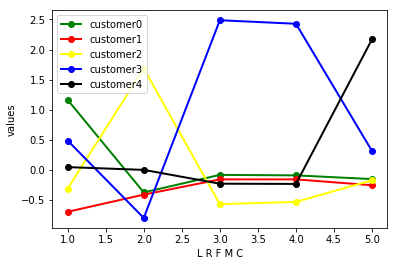

In [13]:
x=[1,2,3,4,5] # match to L R F M C 
colors=['green','red','yellow','blue','black']
for i in range(5):
    plt.plot(x,kmeans.cluster_centers_[i],label=('customer%d'%(i)),linewidth=2,color=colors[i],marker='o')
    plt.legend()
plt.xlabel('L R F M C')
plt.ylabel('values')
plt.show()

Important stable customer: **others high except low R**. Ideal customers with most contribution but least proportion. 

Important potential customer: **others low except high C**. Current value is not high but has potential to be loyal customer

Important retain_required customer: **others low except high L **. Uncertain customers need more interaction to extend their flight service life cycle

General customer: **others low except high R**. 

Low_valued customer: **all low**